In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_num = 2
phase = 0


model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='try10')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

Directory '/Users/mahdiyar/Documents/Data/MotorNet/try10' already exists.


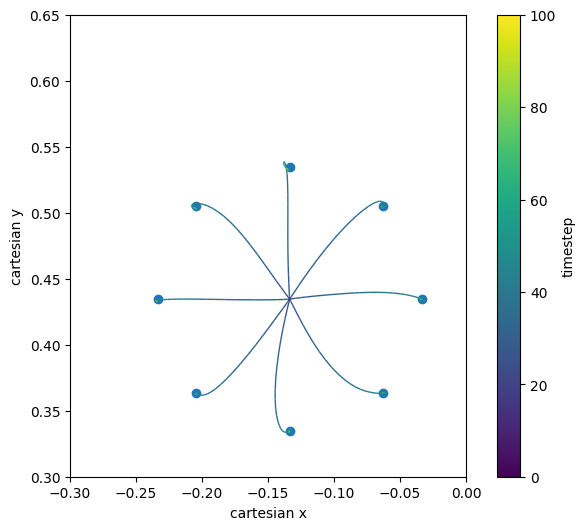

In [3]:
xy, tg, all_hidden, all_muscles = test(cfg_file,weight_file,ff_coefficient=0)
fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg,figsize=(8,6))

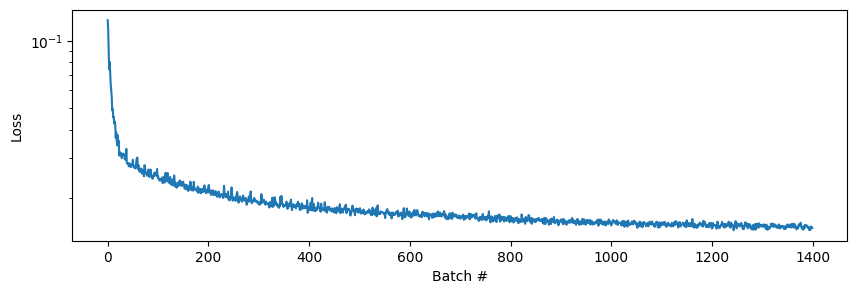

In [4]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log,loss_type='position_loss')

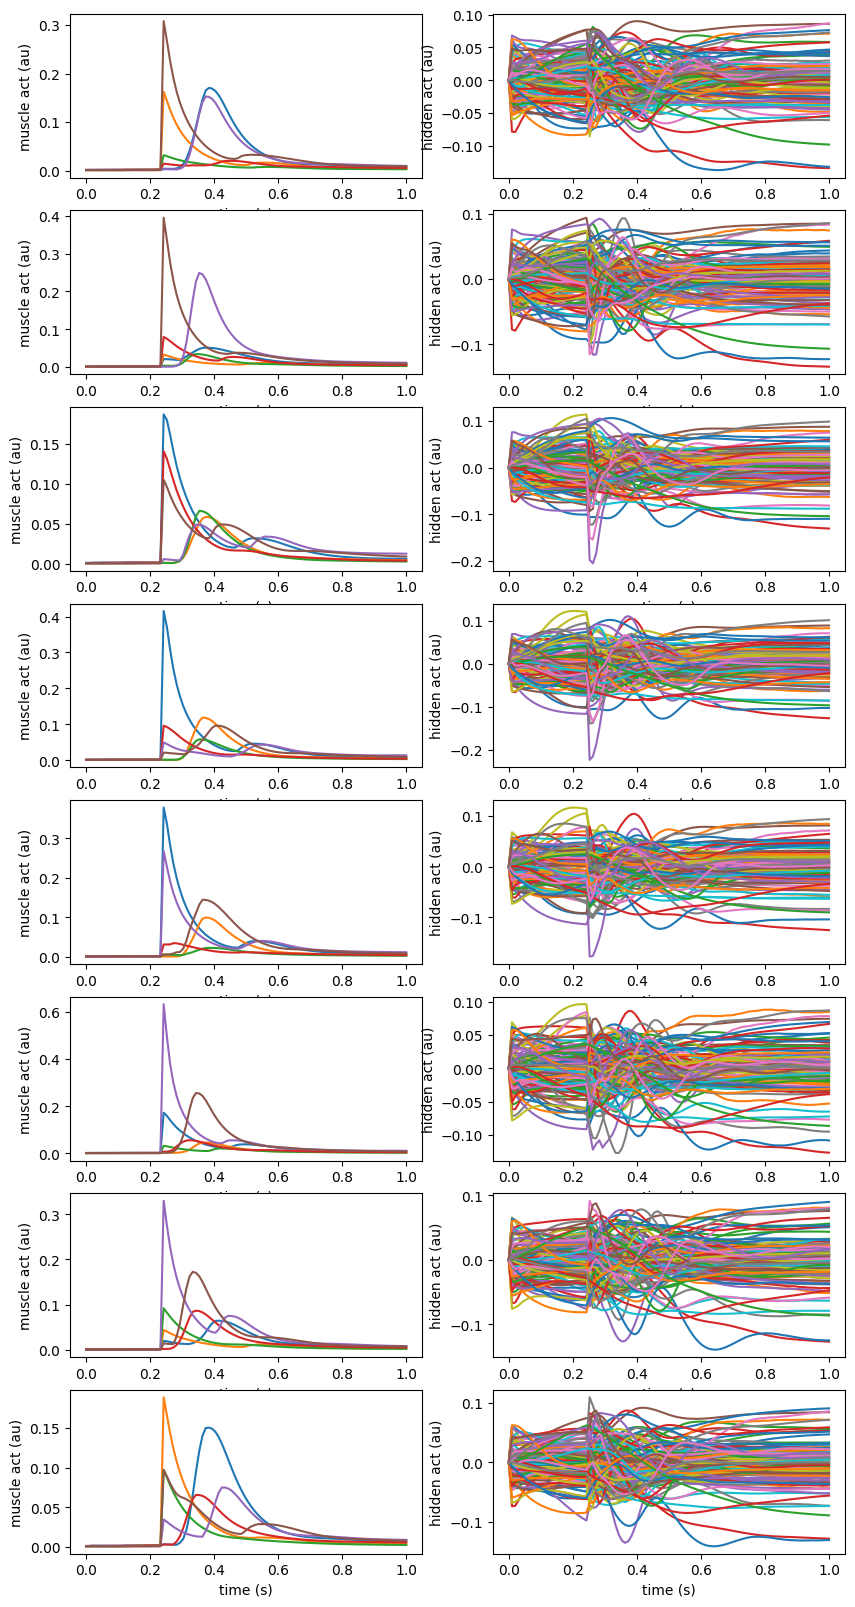

In [5]:
fig, ax = plot.plot_activation(all_hidden, all_muscles)
#fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)

In [9]:
import torch as th
from utils import create_directory, load_env
from task import CentreOutFF
from policy import Policy


output_folder = create_directory(directory_name='try10')
model_name = "model{:02d}".format(model_num)
device = th.device("cpu")

# Set configuaration and network
# load config and weights from the previous phase
phase = 1
weight_file = list(Path(output_folder).glob(f'{model_name}_phase={phase-1}_*_weights'))[0]
cfg_file = list(Path(output_folder).glob(f'{model_name}_phase={phase-1}_*_cfg.json'))[0]

# load configuration
with open(cfg_file,'r') as file:
    cfg = json.load(file)

# environment and network
env = load_env(CentreOutFF,cfg)
policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device, freeze_output_layer=True)
policy.load_state_dict(th.load(weight_file))

Directory '/Users/mahdiyar/Documents/Data/MotorNet/try10' already exists.


<All keys matched successfully>

In [19]:
# Perform PCA on network hidden units trajectories
all_hidden = np.array(all_hidden)
n_mean = np.mean(all_hidden, axis=0, keepdims=True)
rate_scaled = (all_hidden - n_mean)

transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled, method='PCA')

X_ld = transform.transform(rate_scaled,ensure_orthogonality=True)

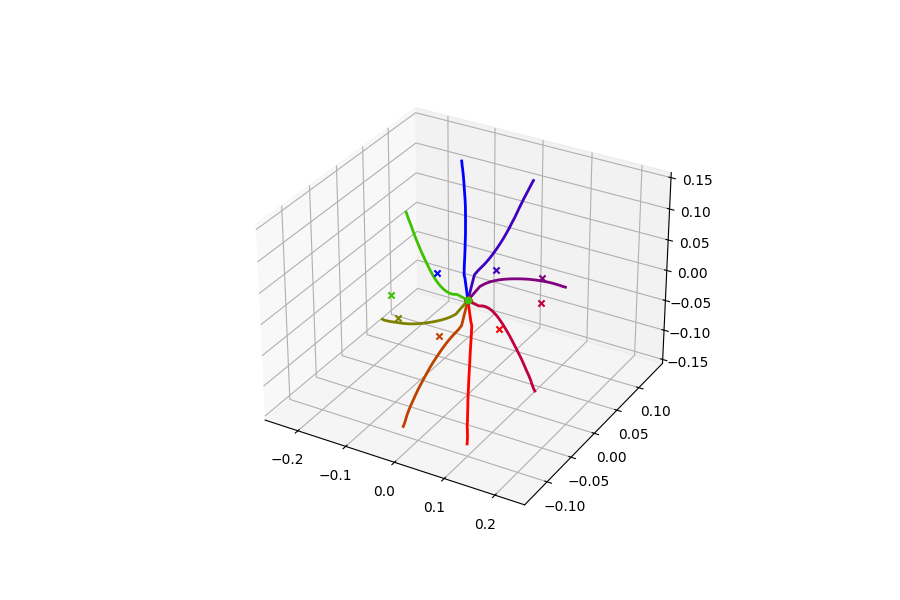

In [20]:
angle_set = np.deg2rad(np.arange(0,360,45)) # 8 directions
reach_angles = []
for cond in angle_set:
    reach_angles.append(plt.cm.brg(cond/(2*np.pi)))

%matplotlib widget
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111,projection='3d')
for c in range(8):
    ax.plot(X_ld[c,:25,0],X_ld[c,:25,1],X_ld[c,:25,2],lw=2,c=reach_angles[c])
    ax.scatter(X_ld[c,0,0],X_ld[c,0,1],X_ld[c,0,2],color=reach_angles[c])
    ax.scatter(X_ld[c,-1,0],X_ld[c,-1,1],X_ld[c,-1,2],marker='x',color=reach_angles[c])

In [55]:
model_num = 1
model_name = "model{:02d}".format(model_num)

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={1}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={1}_*_cfg.json'))[0]

_, _, all_hidden1, _ = test(cfg_file,weight_file,ff_coefficient=0)
all_hidden1 = np.array(all_hidden1)

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={4}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={4}_*_cfg.json'))[0]

_, _, all_hidden3, _ = test(cfg_file,weight_file,ff_coefficient=0)
all_hidden3 = np.array(all_hidden3)

In [56]:
all_hidden = (all_hidden1+all_hidden3)/2

# Perform PCA on network hidden units trajectories
n_mean = np.mean(all_hidden, axis=0, keepdims=True)
rate_scaled = (all_hidden - n_mean)


transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled,method='FA')

In [57]:
X1_ld = transform.transform(all_hidden1-n_mean,ensure_orthogonality=True)
X3_ld = transform.transform(all_hidden3-n_mean,ensure_orthogonality=True)

# n_mean1 = np.mean(all_hidden1, axis=0, keepdims=True)
# X1_ld = transform.transform(all_hidden1-n_mean1,ensure_orthogonality=True)
# n_mean3 = np.mean(all_hidden3, axis=0, keepdims=True)
# X3_ld = transform.transform(all_hidden3-n_mean3,ensure_orthogonality=True)

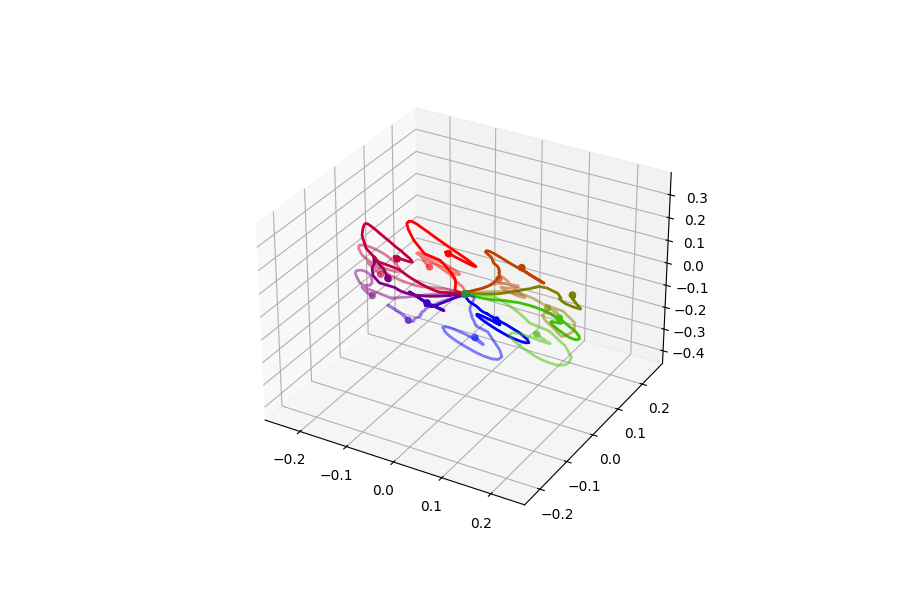

In [58]:
angle_set = np.deg2rad(np.arange(0,360,45)) # 8 directions
reach_angles = []
for cond in angle_set:
    reach_angles.append(plt.cm.brg(cond/(2*np.pi)))

%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111,projection='3d')

for c in range(8):
    ax.plot3D(X1_ld[c,:,0],X1_ld[c,:,1],X1_ld[c,:,2],lw=2,c=reach_angles[c],alpha=1)
    ax.scatter(X1_ld[c,[0,-1],0],X1_ld[c,[0,-1],1],X1_ld[c,[0,-1],2],color=reach_angles[c],alpha=1)

for c in range(8):
    ax.plot3D(X3_ld[c,:,0],X3_ld[c,:,1],X3_ld[c,:,2],lw=2,c=reach_angles[c],alpha=0.5)
    ax.scatter(X3_ld[c,[0,-1],0],X3_ld[c,[0,-1],1],X3_ld[c,[0,-1],2],color=reach_angles[c],alpha=0.5)
    #ax.scatter(X3_ld[c,-1,0],X3_ld[c,-1,1],X3_ld[c,-1,2],marker='x',color=reach_angles[c])

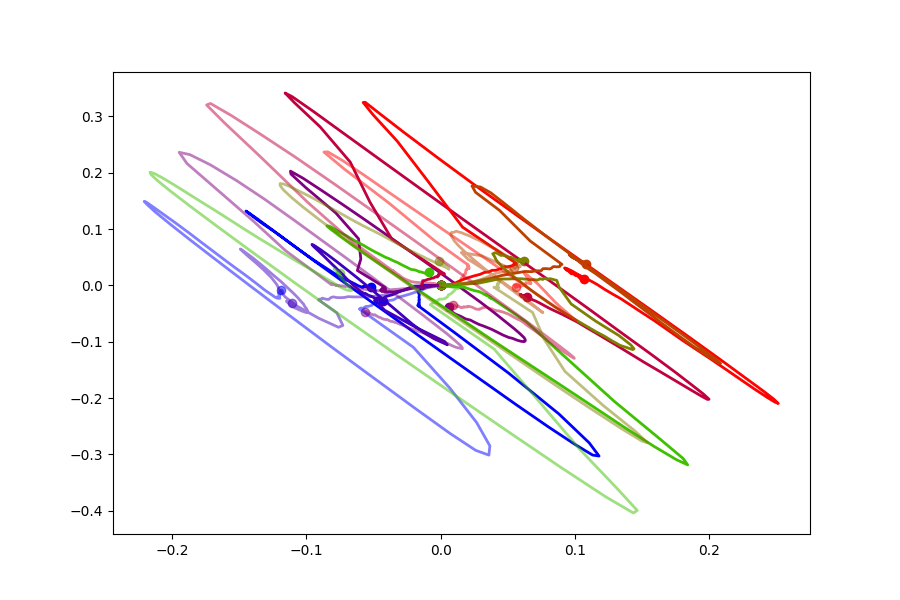

In [60]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

c1=1
c2=2
for c in range(8):
    ax.plot(X1_ld[c,:,c1],X1_ld[c,:,c2],lw=2,c=reach_angles[c],alpha=1)
    ax.scatter(X1_ld[c,[0,-1],c1],X1_ld[c,[0,-1],c2],color=reach_angles[c],alpha=1)

for c in range(8):
    ax.plot(X3_ld[c,:,c1],X3_ld[c,:,c2],lw=2,c=reach_angles[c],alpha=0.5)
    ax.scatter(X3_ld[c,[0,-1],c1],X3_ld[c,[0,-1],c2],color=reach_angles[c],alpha=0.5)